In [1]:
import os
from pathlib import Path
from tqdm import tqdm
import speech_recognition as sr
import pyaudio
import wave
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import librosa
import IPython.display as ipd
import librosa.display

from pathlib import Path

from threading import Thread

In [2]:
ROOT = os.path.join(os.getcwd())
DDIR = os.path.join(os.getcwd(), 'dataset')
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
all_type = ['maju','belok_kiri','belok_kanan','serong_kiri','serong_kanan','stop','putar_balik_kiri', 'putar_balik_kanan', 'other']

In [3]:
def save_dataframe(df:pd.DataFrame, name:str):
    if not os.path.exists('excel'):
        os.makedirs('excel')
    df.to_excel(f'{os.path.join(ROOT, "excel", name)}.xlsx', index=False)
    return print(f'Saved as {name}.xlsx')

In [4]:
def many_files():
    total_files:int = 0
    total_directories:int = 0
    for x in os.listdir(DDIR):
        # print(x)
        print(f'{x}: {len(os.listdir(os.path.join(DDIR, x)))}')
        total_files += len(os.listdir(os.path.join(DDIR, x)))
        total_directories+=1
    print('-=====================-')
    print(f'Total files: {total_files}')
    print(f'Total directories: {total_directories}')

In [5]:
many_files()

belok_kanan: 70
belok_kiri: 70
maju: 101
other: 861
putar_balik_kanan: 40
putar_balik_kiri: 40
serong_kanan: 70
serong_kiri: 70
stop: 70
-=====================-
Total files: 1392
Total directories: 9


In [6]:
from pydub import AudioSegment as am
for x in tqdm(os.listdir(DDIR)):
    for y in os.listdir(os.path.join(DDIR, x)):
        if y.endswith('.wav'):
            sound = am.from_wav(os.path.join(DDIR, x, y))
            sound = sound.set_channels(1)
            sound.export(os.path.join(DDIR, x, y), format='wav')

c:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:01<00:00,  7.22it/s]


In [7]:
def mfcc(audio_obj:str=None, frame_rate:int=2048, hop_len:int=512, mfcc_num:int=100, visualize:bool=True):
    signal, sr = librosa.load(audio_obj)
    mfcc_spectrum = librosa.feature.mfcc(y=signal, sr=sr, n_fft=frame_rate, hop_length=hop_len, n_mfcc=mfcc_num)
    # delta_1_mfcc = librosa.feature.delta(mfcc_spectrum, order=1)
    # delta_2_mfcc = librosa.feature.delta(mfcc_spectrum, order=2)

    mfcc_features = np.mean(mfcc_spectrum, axis=1)

    if visualize:
        plt.figure(figsize=(14, 15))
        plt.subplot(3, 1, 1)
        librosa.display.specshow(mfcc_spectrum, sr=sr, hop_length=hop_len, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC of {audio_obj}')

        plt.subplot(3, 1, 2)
        librosa.display.specshow(delta_1_mfcc, sr=sr, hop_length=hop_len, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC Delta 1 of {audio_obj}')

        plt.subplot(3, 1, 3)
        librosa.display.specshow(delta_2_mfcc, sr=sr, hop_length=hop_len, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC Delta 2 of {audio_obj}')

        plt.tight_layout()
        plt.show()
    return mfcc_features

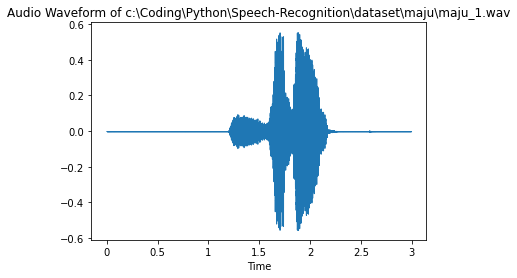

In [8]:
test_input = os.path.join(DDIR, 'maju', 'maju_1.wav')
audio_obj = ipd.Audio(test_input)
audio, sr = librosa.load(test_input)

librosa.display.waveshow(audio , sr=sr)
plt.title(f'Audio Waveform of {test_input}')
plt.show()

In [51]:
def audio_features(path:os.PathLike=DDIR, frame_size:int=2048, hop_len:int=512, mfcc_num:int=100):
    audio_files = os.listdir(path)
    list_df = []
    # print(audio_files)
    for audio_name in tqdm(audio_files):
        audios_mfcc,audios_label = [],[]
        for audio in glob.glob(f'{os.path.join(DDIR , audio_name)}/*.wav'):
            mfcc_score = mfcc(audio_obj=audio, frame_rate=frame_size, hop_len=hop_len, mfcc_num=mfcc_num, visualize=False)
        # mfcc_score = mfcc(audio_obj=f'{os.path.join(path, audio_name)}', frame_rate=frame_size, hop_len=hop_len, mfcc_num=mfcc_num, visualize=False)
        
            audios_mfcc.append(mfcc_score)
            if(audio_name != 'other'):
                label = audio.split('\\')[-1].split('_')
                label = '_'.join(label[:len(label)-1])
            else:
                label = 'other'
            audios_label.append(label)

    # print(len(audios_mfcc), len(audios_zcr), len(audios_rmse), len(audios_label))
    # print(audios_mfcc[0].shape, audios_zcr[0].shape, audios_rmse[0].shape)
        audio_features = np.column_stack(audios_mfcc)
        # print(audio_features.shape)
        df = pd.DataFrame(audio_features)
        df = df.T
        # df.insert(loc=0, column='name', value=audio_label)
        df['label'] = audios_label

        list_df.append(df)
    return list_df

In [52]:
belok_kanan, belok_kiri, maju, other, putar_balik_kanan, putar_balik_kiri, serong_kanan, serong_kiri, stop = audio_features(path=DDIR, frame_size=2048, hop_len=512, mfcc_num=100)

100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


In [ ]:
# belok_kanan_df = audio_features(path=os.path.join(DDIR, 'belok_kanan'), frame_size=2048, hop_len=512, mfcc_num=100)

In [56]:
serong_kanan

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-380.074615,58.260147,-0.587196,9.357736,3.998401,3.897801,0.967041,-2.311783,1.511695,4.123258,...,0.103644,0.277166,0.268819,0.011929,0.294096,0.106548,-0.174768,-0.238971,-0.150358,serong_kanan
1,-400.412933,81.056763,1.259394,11.193357,3.868623,-0.593123,2.365073,-0.667273,3.388696,3.677302,...,-0.481262,-0.267577,0.052987,-0.393829,-0.085509,0.070544,-0.349475,-0.379528,-0.013909,serong_kanan
2,-428.661133,57.479919,-3.349911,10.057857,2.756717,2.204338,3.409310,-0.366781,1.402641,1.862988,...,-0.279529,-0.560101,-0.333088,-0.392702,-0.421262,-0.210110,-0.244184,-0.572543,-0.379502,serong_kanan
3,-453.865479,56.457405,-4.492160,15.571338,7.973554,3.145535,5.847776,1.554070,3.103191,3.556479,...,-0.152805,-0.324230,-0.354708,-0.294237,-0.078342,-0.366582,-0.499392,-0.364386,0.106265,serong_kanan
4,-429.726074,53.000835,3.172668,13.910784,6.190843,5.544556,5.674410,2.104498,2.150882,3.181381,...,-0.371757,0.021584,-0.126865,-0.640334,-0.314716,-0.272022,-0.275173,-0.512959,-0.020131,serong_kanan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-413.330048,91.826759,-13.520096,12.449458,-6.344860,-3.899706,-10.751988,-6.284375,-3.352993,-1.283983,...,0.772176,-0.397521,-0.013804,-0.016437,0.170985,-0.719831,0.314722,-0.195510,0.333085,serong_kanan
66,-459.121399,66.951698,-8.877245,6.516498,5.150327,1.190079,4.391885,-2.318023,0.781615,4.962187,...,-0.297946,-0.326064,-0.167865,-0.765484,-0.504372,-0.348878,-0.275341,-0.667133,-0.536790,serong_kanan
67,-398.608765,83.548889,-8.661835,9.612595,-8.487599,-2.952939,-9.160398,-5.155799,-0.947111,-3.292830,...,0.119287,-0.450644,-0.487116,-0.218017,0.770610,-0.383795,0.611041,-0.324078,0.636435,serong_kanan
68,-367.660431,96.229057,-6.241835,10.018987,3.433935,-5.628638,-3.239011,-3.085521,2.122401,0.175545,...,0.123640,-0.444557,-0.042744,-0.506295,0.096704,-0.319243,-0.745191,-0.960637,0.087991,serong_kanan


In [57]:
df = pd.concat([belok_kanan, belok_kiri, maju, other, putar_balik_kanan, putar_balik_kiri, serong_kanan, serong_kiri, stop], ignore_index=True)

In [58]:
df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,-422.895020,48.039368,-6.186774,5.216863,0.528688,0.511103,0.804288,-2.947132,-1.912176,-1.176030,...,0.210378,-0.140555,0.035365,0.327993,0.097341,-0.261531,-0.144780,-0.032475,-0.001613,belok_kanan
1,-452.015533,75.630280,3.107103,13.786242,10.602611,5.711093,9.261926,1.144305,-0.127123,4.809555,...,-0.385292,-0.396922,-0.195165,-0.274765,-0.303379,-0.565148,-0.229500,-0.267201,-0.383995,belok_kanan
2,-451.404572,79.344475,6.550086,13.724059,8.741273,5.700652,10.009722,4.446376,1.270512,4.347304,...,-0.593732,-0.846818,-0.305814,-0.309355,-0.451223,-0.471889,-0.150527,-0.357839,-0.259098,belok_kanan
3,-427.350311,74.012665,7.923713,17.727348,10.162389,3.991512,8.650618,0.311897,-0.763944,3.620642,...,-0.425157,-0.406701,-0.035334,0.104050,0.104159,0.058649,0.134681,-0.026266,-0.043817,belok_kanan
4,-429.572540,77.107819,-4.081679,11.423177,7.030103,0.563384,7.570338,-4.722734,-2.023028,2.345480,...,0.149114,-0.059289,-0.046067,-0.156633,-0.080537,-0.378049,-0.367593,-0.280759,-0.146725,belok_kanan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-439.343872,68.687637,-4.124946,11.329474,-13.870933,-7.643499,-7.563810,-9.284710,-10.797133,-6.806800,...,0.284399,-0.495317,0.581074,0.852153,1.863903,0.968527,0.893895,0.371343,1.226156,stop
796,-476.851288,33.758762,3.198869,18.945076,9.691606,5.707524,5.860674,2.288089,3.738406,4.480802,...,-0.358294,0.049894,-0.758487,-0.712967,0.095471,-0.591564,-0.945470,-0.110622,0.733492,stop
797,-438.457001,72.185982,-6.380831,12.022658,-13.687881,-8.178506,-8.641500,-10.645189,-12.737346,-6.132538,...,0.537573,-0.407670,0.663131,0.907754,1.351816,0.358934,1.034336,0.698511,1.439974,stop
798,-460.523193,42.417267,2.463290,13.035515,12.209575,12.237802,9.284326,2.712193,3.275745,6.846437,...,0.161486,-0.459517,-0.297796,0.236673,0.043918,-0.808160,-0.217420,0.176083,-0.242040,stop


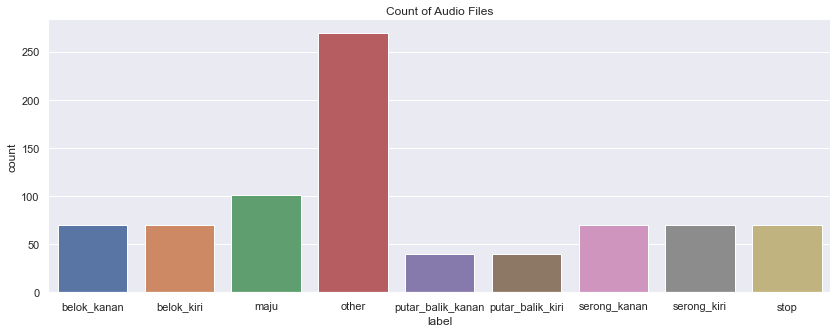

In [59]:
sns.set()
plt.figure(figsize=(14, 5))
sns.countplot(x='label', data=df)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.title('Count of Audio Files')
plt.show()

In [67]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split as tts

all_data = belok_kanan.drop(['label'], axis=1)

X = df.drop(['label'], axis=1)

scaler = MinMaxScaler()
scaler = scaler.fit(X)
all_data = scaler.transform(all_data)

maps = {
    'maju': 0,
    'belok_kiri': 1,
    'belok_kanan': 2,
    'serong_kiri': 3,
    'serong_kanan': 4,
    'stop': 5,
    'putar_balik_kiri': 6,
    'putar_balik_kanan': 7,
    'other': 8
}

all_data_y = list(map(lambda x : maps[x], belok_kanan['label']))

X_train, X_test, y_train, y_test = tts(all_data, all_data_y, test_size=0.2)

for data in belok_kiri, maju, other, putar_balik_kanan, putar_balik_kiri, serong_kanan, serong_kiri, stop:
    X = data.drop(['label'], axis=1)
    X = scaler.transform(X)
    y = list(map(lambda x : maps[x], data['label']))
    # display(data['label'])
    xtrain, xtest, ytrain, ytest = tts(X,y, test_size=0.2)
    X_train = np.concatenate((X_train, xtrain), axis=0)
    X_test = np.concatenate((X_test, xtest), axis=0)
    y_train = np.concatenate((y_train, ytrain), axis=0)
    y_test = np.concatenate((y_test, ytest), axis=0)
# X = df.drop(['label'], axis=1)

# scaler = MinMaxScaler()
# scaler = scaler.fit(X)
# X = scaler.transform(X)

# X = np.expand_dims(X, axis=-1)

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# y = list(map(lambda x : maps[x], df['label']))

# y = pd.get_dummies(df['label']).values
# y = np.reshape(y, (len(y), 8,1))

# y = y.reshape(-1, 8)
# y = OneHotEncoder().fit_transform(df_fix['label'].values.reshape(-1, 1)).toarray()
# y = np.array(df_fix['label'].apply(lambda x : 1 if x == 'happy' else 0))

# y = np.reshape(y, (-1, 1))
# y = OneHotEncoder().fit_transform(y).toarray()


In [68]:
df['label'].value_counts()

other                269
maju                 101
belok_kanan           70
belok_kiri            70
serong_kanan          70
serong_kiri           70
stop                  70
putar_balik_kanan     40
putar_balik_kiri      40
Name: label, dtype: int64

In [69]:
X_train

array([[0.6330638 , 0.46399277, 0.5441993 , ..., 0.47559488, 0.7037136 ,
        0.79877996],
       [0.6532226 , 0.4736271 , 0.4506573 , ..., 0.38716868, 0.652891  ,
        0.49530283],
       [0.60896105, 0.4945867 , 0.46695268, ..., 0.65060145, 0.7637622 ,
        0.6990978 ],
       ...,
       [0.6381479 , 0.14730245, 0.5560346 , ..., 0.269003  , 0.65699625,
        0.40945894],
       [0.6045723 , 0.13104008, 0.56914794, ..., 0.24020809, 0.632949  ,
        0.5771213 ],
       [0.60624623, 0.4147704 , 0.5120363 , ..., 0.5426171 , 0.7760685 ,
        0.715785  ]], dtype=float32)

In [70]:
from sklearn.svm import SVC
def svm_train(X_train, X_test, y_train, y_test, kernel:str='linear', C:float=1.0, gamma:str|int=None, dfs:str=None):
    svc = SVC(kernel=kernel, C=C, gamma=gamma, decision_function_shape=dfs, probability=True)
    svc.fit(X_train, y_train)
    y2 = svc.predict(X_test)
    return accuracy_score(y_test, y2)

In [71]:
def get_svm(X_train, X_test, y_train, y_test)->pd.DataFrame:
    df = pd.DataFrame(columns=['kernel', 'C', 'accuracy (%)','gamma','decision_function_shape'])
    list_gamma = [0.0001, 0.1, 1]
    list_dfs = ['ovo','ovr']
    for a in tqdm(list_dfs):
        for x in [1, 10, 100]:
            for y in ['linear', 'rbf', 'sigmoid']:
                for z in list_gamma:
                    acc = svm_train(X_train, X_test, y_train, y_test, y, x, gamma=z, dfs=a)
                    df = df.append({'kernel': y, 'C': x, 'accuracy (%)': acc.round(2), 'gamma': z, 'decision_function_shape':a}, ignore_index=True)
    return df

In [72]:
get_svm_score = get_svm(X_train, X_test, y_train, y_test)

100%|██████████| 2/2 [00:06<00:00,  3.10s/it]


In [73]:
get_svm_score.sort_values(by='accuracy (%)', ascending=False)

,kernel,C,accuracy (%),gamma,decision_function_shape
22,rbf,100,0.98,0.1000,ovo
49,rbf,100,0.98,0.1000,ovr
40,rbf,10,0.96,0.1000,ovr
13,rbf,10,0.96,0.1000,ovo
47,linear,100,0.94,1.0000,ovr
46,linear,100,0.94,0.1000,ovr
45,linear,100,0.94,0.0001,ovr
41,rbf,10,0.94,1.0000,ovr
20,linear,100,0.94,1.0000,ovo
23,rbf,100,0.94,1.0000,ovo


In [74]:
get_svm_score.sort_values(by='accuracy (%)', ascending=False, inplace=True)

In [75]:
get_svm_score['rank'] = np.arange(1,len(get_svm_score)+1)

In [76]:
get_svm_score.set_index = get_svm_score['rank']

In [77]:
save_dataframe(get_svm_score, 'svm_score')

Saved as svm_score.xlsx


In [78]:
best = get_svm_score.iloc[0]

In [79]:
ticks_list = maps.keys()

In [80]:
ticks_list = list(ticks_list)
ticks_list

['maju',
 'belok_kiri',
 'belok_kanan',
 'serong_kiri',
 'serong_kanan',
 'stop',
 'putar_balik_kiri',
 'putar_balik_kanan',
 'other']

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        21
           1       0.88      1.00      0.93        14
           2       0.93      0.93      0.93        14
           3       1.00      1.00      1.00        14
           4       0.93      1.00      0.97        14
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00        54

    accuracy                           0.98       161
   macro avg       0.97      0.98      0.97       161
weighted avg       0.98      0.98      0.97       161

Accuracy : 97.52%


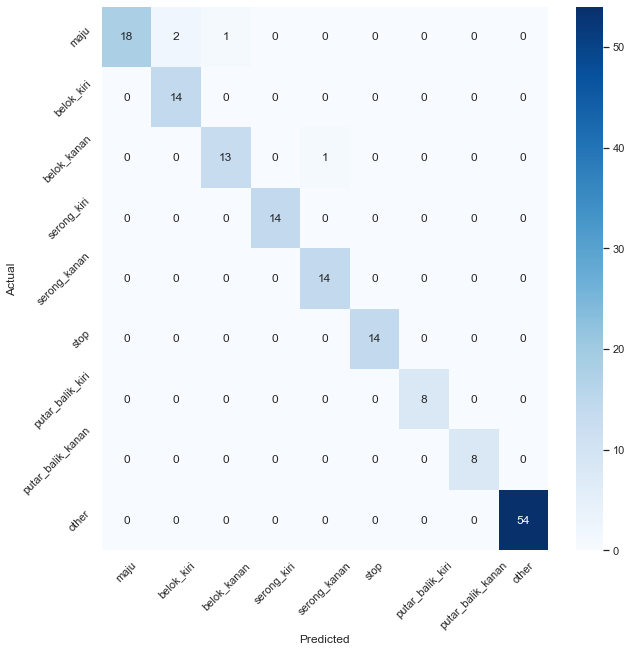

In [81]:
svm_score = SVC(kernel=best['kernel'],C=best['C'], gamma=best['gamma'], decision_function_shape=best['decision_function_shape'], probability=True)
svm_score.fit(X_train, y_train)
y_pred = svm_score.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Accuracy : {accuracy_score(y_test, y_pred).round(4)*100}%')
matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
ax = sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.xticks(np.arange(9)+0.5, ticks_list, rotation=45)
plt.ylabel('Actual')
plt.yticks(np.arange(9)+0.5, ticks_list, rotation=45)
plt.show()

In [82]:
def prediction(model:object=None, df:pd.DataFrame=None):
    temp = df
    X = temp.drop(['label'], axis=1)
    # scaler = MinMaxScaler()
    X = scaler.transform(X)
    y = list(map(lambda x : maps[x], temp['label']))
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    fig = plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.xticks(np.arange(9)+0.5, ticks_list, rotation=45)
    plt.ylabel('Actual')
    plt.yticks(np.arange(9)+0.5, ticks_list, rotation=45)
    plt.show()
    
    for i in range(len(y)):
        print(f'Prediction for {temp["label"].iloc[i]}_{i+1} : {y_pred[i]}')

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       101
           1       0.97      1.00      0.99        70
           2       0.99      0.99      0.99        70
           3       1.00      1.00      1.00        70
           4       0.99      1.00      0.99        70
           5       1.00      1.00      1.00        70
           6       1.00      1.00      1.00        40
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00       269

    accuracy                           0.99       800
   macro avg       0.99      1.00      0.99       800
weighted avg       1.00      0.99      0.99       800



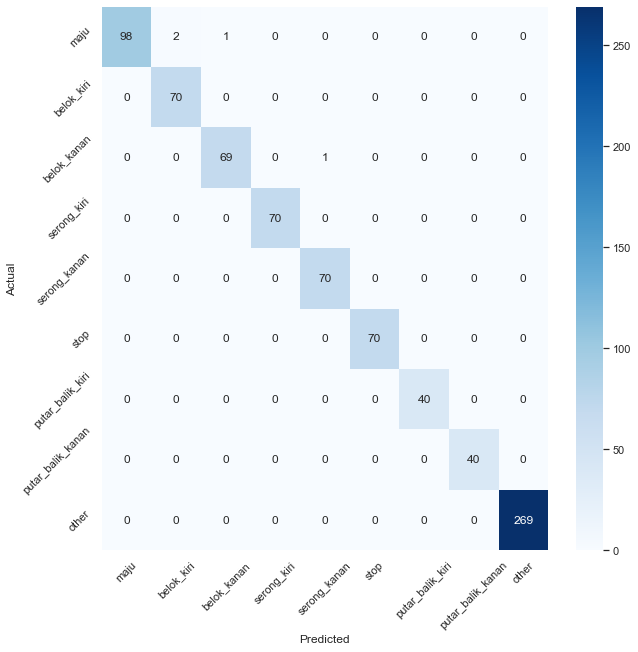

Prediction for belok_kanan_1 : 2
Prediction for belok_kanan_2 : 2
Prediction for belok_kanan_3 : 2
Prediction for belok_kanan_4 : 2
Prediction for belok_kanan_5 : 2
Prediction for belok_kanan_6 : 4
Prediction for belok_kanan_7 : 2
Prediction for belok_kanan_8 : 2
Prediction for belok_kanan_9 : 2
Prediction for belok_kanan_10 : 2
Prediction for belok_kanan_11 : 2
Prediction for belok_kanan_12 : 2
Prediction for belok_kanan_13 : 2
Prediction for belok_kanan_14 : 2
Prediction for belok_kanan_15 : 2
Prediction for belok_kanan_16 : 2
Prediction for belok_kanan_17 : 2
Prediction for belok_kanan_18 : 2
Prediction for belok_kanan_19 : 2
Prediction for belok_kanan_20 : 2
Prediction for belok_kanan_21 : 2
Prediction for belok_kanan_22 : 2
Prediction for belok_kanan_23 : 2
Prediction for belok_kanan_24 : 2
Prediction for belok_kanan_25 : 2
Prediction for belok_kanan_26 : 2
Prediction for belok_kanan_27 : 2
Prediction for belok_kanan_28 : 2
Prediction for belok_kanan_29 : 2
Prediction for belok_ka

In [83]:
prediction(svm_score, df)

In [84]:
import pickle

def save_model(model:object=None, name:str=None):
    if not os.path.exists('model'):
        os.makedirs('model')
    pickle.dump(model, open(f'{os.path.join(ROOT, "model", name)}.pkl', 'wb'))
    return print(f'Saved as {name}.pkl')

save_model(svm_score, 'svm_model_speech_recognition')

save_model(scaler, 'svm_scaler_speech_recognition')

Saved as svm_model_speech_recognition.pkl
Saved as svm_scaler_speech_recognition.pkl


In [85]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

In [86]:
X = df.drop(['label'], axis=1)
X = scaler.transform(X)
y = list(map(lambda x : maps[x], df['label']))
y = np.reshape(y, (-1, 1))

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)

In [87]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(filters=hp.Choice('filters', [16,32,64])
                                             ,kernel_size=3
                                             ,activation='relu'
                                             ,kernel_initializer='he_normal'
                                             ,padding='same'))
    model.add(layers.MaxPooling1D(3, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    for i in range(hp.Int('num_layers', 3, 6)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
        model.add(layers.BatchNormalization())

    model.add(layers.Dense(9, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [88]:
tuner = kt.Hyperband(hypermodel=build_model,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     hyperband_iterations=3,
                     seed=42,
                     overwrite=True)

In [89]:
tuner.search(x=X_train,
             y=y_train,
             validation_split=0.2,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)], 
             epochs=30         
            )

Trial 762 Complete [00h 00m 05s]
val_accuracy: 0.4609375

Best val_accuracy So Far: 0.9765625
Total elapsed time: 00h 49m 17s
INFO:tensorflow:Oracle triggered exit


In [90]:
best_hp = tuner.get_best_hyperparameters()[0]
final_model = tuner.hypermodel.build(best_hp)

final_model_history = final_model.fit(x=X_train,
                                      y=y_train,
                                      validation_split=0.2,
                                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)],
                                      epochs=50)

Epoch 1/50
16/16 [==============================] - 2s 15ms/step - loss: 1.5519 - accuracy: 0.4590 - val_loss: 2.0068 - val_accuracy: 0.3438
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.6729 - accuracy: 0.7988 - val_loss: 1.9210 - val_accuracy: 0.3438
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.4567 - accuracy: 0.8848 - val_loss: 1.8684 - val_accuracy: 0.3672
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.2960 - accuracy: 0.9180 - val_loss: 1.8210 - val_accuracy: 0.4062
Epoch 5/50
16/16 [==============================] - 0s 5ms/step - loss: 0.2380 - accuracy: 0.9336 - val_loss: 1.7783 - val_accuracy: 0.4531
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 0.1945 - accuracy: 0.9453 - val_loss: 1.7300 - val_accuracy: 0.4609
Epoch 7/50
16/16 [==============================] - 0s 7ms/step - loss: 0.1465 - accuracy: 0.9570 - val_loss: 1.6575 - val_accuracy: 0.4766
Epoch 8/50
16/16 [=

In [91]:
save_model(final_model, 'cnn_model_speech_recognition')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\conv1d
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling1d
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.....